<a href="https://colab.research.google.com/github/sway-am/Interpretability-of-CNN-during-PV-classification/blob/main/Solar_Thermography_Interpretability.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [15]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [16]:
%cd /content/gdrive/MyDrive/Kaggle

/content/gdrive/MyDrive/Kaggle


In [17]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = '/content/gdrive/MyDrive/Kaggle'


In [18]:
!kaggle datasets download -d marcosgabriel/infrared-solar-modules

 33% 5.00M/15.2M [00:00<00:00, 34.6MB/s]
100% 15.2M/15.2M [00:00<00:00, 66.6MB/s]


In [22]:
#unzipping the zip files and deleting the zip files
!unzip \*.zip  && rm *.zip

Streaming output truncated to the last 5000 lines.
  inflating: 2020-02-14_InfraredSolarModules/InfraredSolarModules/images/5500.jpg  
  inflating: 2020-02-14_InfraredSolarModules/InfraredSolarModules/images/5501.jpg  
  inflating: 2020-02-14_InfraredSolarModules/InfraredSolarModules/images/5502.jpg  
  inflating: 2020-02-14_InfraredSolarModules/InfraredSolarModules/images/5503.jpg  
  inflating: 2020-02-14_InfraredSolarModules/InfraredSolarModules/images/5504.jpg  
  inflating: 2020-02-14_InfraredSolarModules/InfraredSolarModules/images/5505.jpg  
  inflating: 2020-02-14_InfraredSolarModules/InfraredSolarModules/images/5506.jpg  
  inflating: 2020-02-14_InfraredSolarModules/InfraredSolarModules/images/5507.jpg  
  inflating: 2020-02-14_InfraredSolarModules/InfraredSolarModules/images/5508.jpg  
  inflating: 2020-02-14_InfraredSolarModules/InfraredSolarModules/images/5509.jpg  
  inflating: 2020-02-14_InfraredSolarModules/InfraredSolarModules/images/551.jpg  
  inflating: 2020-02-14_In

In [23]:
# genral imports
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt

# deep learning
import cv2
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from tensorflow.keras.utils import to_categorical

In [24]:
DATA_PATH = '/content/gdrive/MyDrive/Kaggle/2020-02-14_InfraredSolarModules/InfraredSolarModules'
METADATA_PATH = os.path.join(DATA_PATH, 'module_metadata.json')
df = pd.read_json(METADATA_PATH, orient='index').sort_index()
df['image_filepath'] = df.image_filepath.apply(lambda x: os.path.join(DATA_PATH, x))
df

,image_filepath,anomaly_class
0,/content/gdrive/MyDrive/Kaggle/2020-02-14_Infr...,Offline-Module
1,/content/gdrive/MyDrive/Kaggle/2020-02-14_Infr...,Offline-Module
2,/content/gdrive/MyDrive/Kaggle/2020-02-14_Infr...,Offline-Module
3,/content/gdrive/MyDrive/Kaggle/2020-02-14_Infr...,Offline-Module
4,/content/gdrive/MyDrive/Kaggle/2020-02-14_Infr...,Offline-Module
...,...,...
19995,/content/gdrive/MyDrive/Kaggle/2020-02-14_Infr...,No-Anomaly
19996,/content/gdrive/MyDrive/Kaggle/2020-02-14_Infr...,No-Anomaly
19997,/content/gdrive/MyDrive/Kaggle/2020-02-14_Infr...,No-Anomaly
19998,/content/gdrive/MyDrive/Kaggle/2020-02-14_Infr...,No-Anomaly


In [25]:
crystal_df = df.query('anomaly_class != ("Hot-Spot", "Hot-Spot-Multi")')
crystal_df

,image_filepath,anomaly_class
0,/content/gdrive/MyDrive/Kaggle/2020-02-14_Infr...,Offline-Module
1,/content/gdrive/MyDrive/Kaggle/2020-02-14_Infr...,Offline-Module
2,/content/gdrive/MyDrive/Kaggle/2020-02-14_Infr...,Offline-Module
3,/content/gdrive/MyDrive/Kaggle/2020-02-14_Infr...,Offline-Module
4,/content/gdrive/MyDrive/Kaggle/2020-02-14_Infr...,Offline-Module
...,...,...
19995,/content/gdrive/MyDrive/Kaggle/2020-02-14_Infr...,No-Anomaly
19996,/content/gdrive/MyDrive/Kaggle/2020-02-14_Infr...,No-Anomaly
19997,/content/gdrive/MyDrive/Kaggle/2020-02-14_Infr...,No-Anomaly
19998,/content/gdrive/MyDrive/Kaggle/2020-02-14_Infr...,No-Anomaly


In [26]:
df['image_filepath'][0]

'/content/gdrive/MyDrive/Kaggle/2020-02-14_InfraredSolarModules/InfraredSolarModules/images/0.jpg'

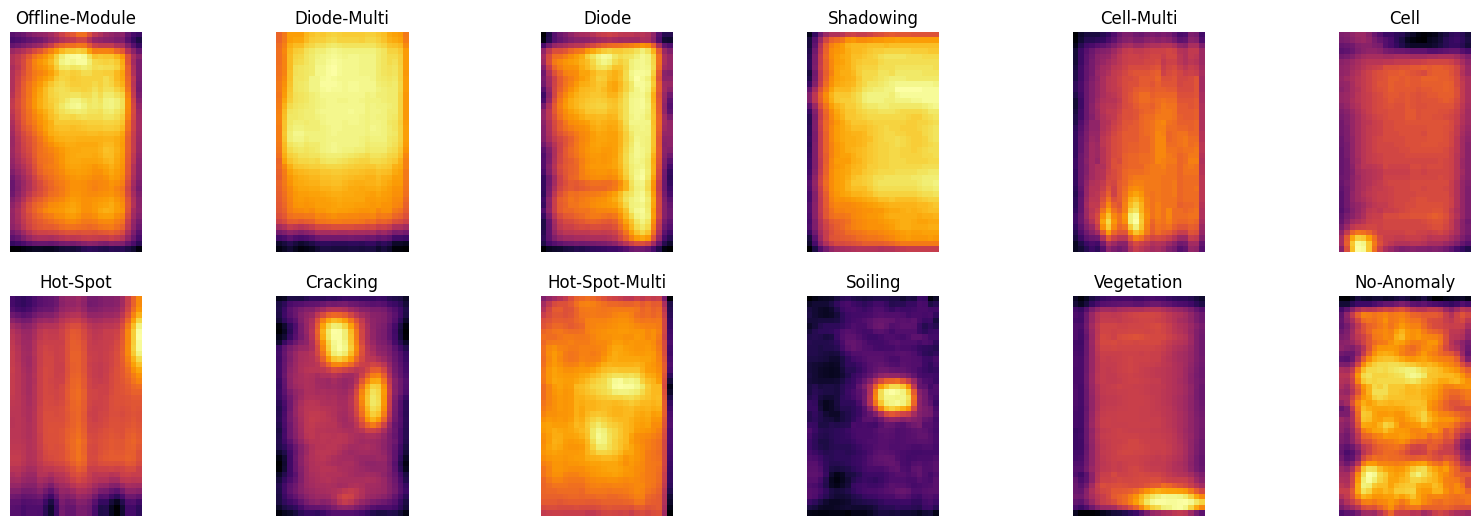

In [27]:
# Get unique anomaly classes
unique_classes = df['anomaly_class'].unique()

# Plot the sampled images
plt.figure(figsize=(20, 20))

for i, class_name in enumerate(unique_classes, start=1):
    # Sample one image for each class
    sample = df[df['anomaly_class'] == class_name].sample(n=1).iloc[0]

    image = cv2.imread(sample['image_filepath'], 0)

    plt.subplot(6, 6, i)
    plt.imshow(image, cmap='inferno')
    plt.title(class_name)
    plt.axis('off')

plt.show()


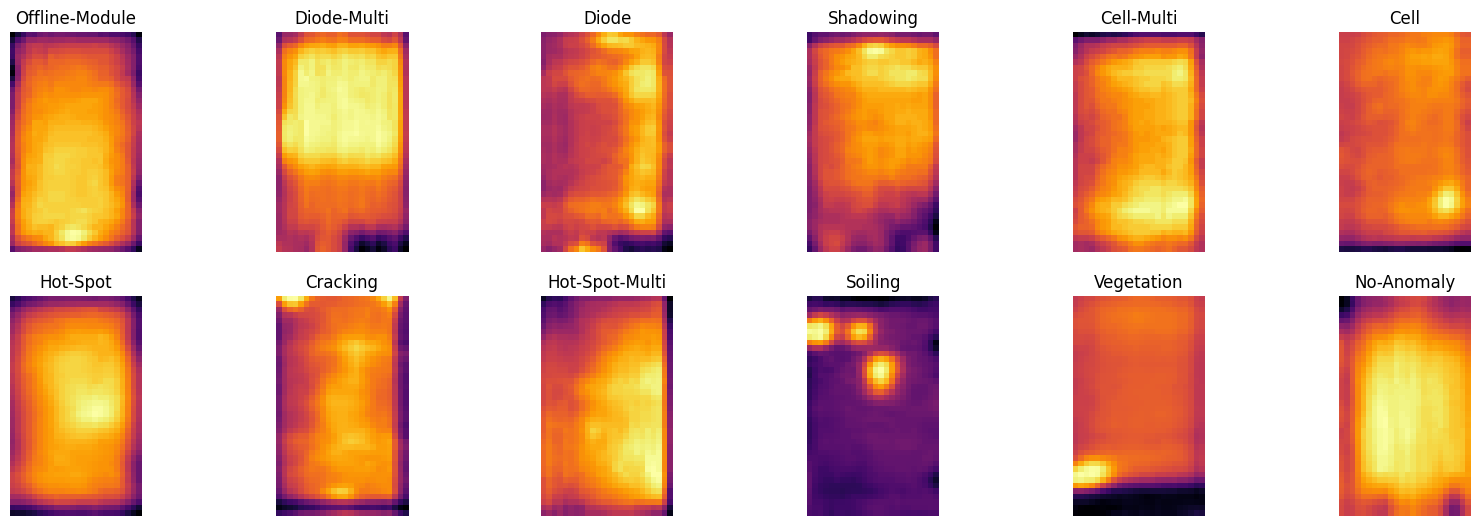

In [28]:
# Get unique anomaly classes
unique_classes = df['anomaly_class'].unique()

# Plot the sampled images
plt.figure(figsize=(20, 20))

for i, class_name in enumerate(unique_classes, start=1):
    # Sample one image for each class
    sample = df[df['anomaly_class'] == class_name].sample(n=1).iloc[0]

    image = cv2.imread(sample['image_filepath'], 0)

    plt.subplot(6, 6, i)
    plt.imshow(image, cmap='inferno')
    plt.title(class_name)
    plt.axis('off')

plt.show()


In [29]:
remaining_labels = ['No-Anomaly','Cell','Vegetation','Diode','Cell-Multi','Shadowing','Cracking','Offline-Module','Soiling','Diode-Multi']

In [30]:
train = []
labels = []
for label in remaining_labels:
    filtered_df = df[df['anomaly_class'] == label]




    for image_filepath in filtered_df['image_filepath']:
        try:
            # Read the image using OpenCV
            img = cv2.imread(image_filepath)

            # Convert the image to a numpy array
            img = np.array(img)

            # Append the resized image array to the list
            train.append(img)
            labels.append(label)


        except Exception as e:
            # Handle exceptions (e.g., if the image file is corrupted or cannot be read)
            print(f"Error processing image {image_filepath}: {str(e)}")

# Convert the list of arrays to a numpy array
train = np.array(train)

In [31]:

labels = np.array(labels)

In [32]:
new_types = []

for i in range(labels.shape[0]):
    if labels[i] == "Cell":
        new_types.append(0)
    elif labels[i] == 'Cell-Multi':
        new_types.append(1)
    elif labels[i] == 'Cracking':
        new_types.append(2)
    elif labels[i] == 'Diode':
        new_types.append(3)
    elif labels[i] == 'Diode-Multi':
        new_types.append(4)
    elif labels[i] == 'No-Anomaly':
        new_types.append(5)
    elif labels[i] == 'Offline-Module':
        new_types.append(6)
    elif labels[i] == 'Shadowing':
        new_types.append(7)
    elif labels[i] == 'Soiling':
        new_types.append(8)
    elif labels[i] == 'Vegetation':
        new_types.append(9)

new_types = np.array(new_types)
new_types.shape

(19505,)

In [33]:
X_train, X_test, y_train, y_test = train_test_split( train, new_types, test_size=0.2, random_state=42)

In [34]:
from imblearn.over_sampling import SMOTE
from collections import Counter

# Count the occurrences of each class in the original dataset
y = y_train
print("Class distribution before oversampling:", Counter(y))

X = X_train

# Reshape X if it's a 3D array (e.g., RGB images)
if len(X.shape) == 4:
    # If images are RGB, reshape to (num_samples, height * width * channels)
    X = X.reshape(X.shape[0], -1)

# Create a SMOTE oversampler
smote = SMOTE(random_state=42)

# Fit and apply the oversampler
X_resampled, y_resampled = smote.fit_resample(X, y)

# If you reshaped the input, reshape it back to its original shape
if len(X.shape) == 2:
    X_resampled = X_resampled.reshape(X_resampled.shape[0], 40, 24, 3)

# Count the occurrences of each class after oversampling
print("Class distribution after oversampling:", Counter(y_resampled))


Class distribution before oversampling: Counter({5: 7977, 0: 1521, 9: 1303, 3: 1202, 1: 1025, 7: 845, 2: 758, 6: 668, 8: 164, 4: 141})
Class distribution after oversampling: Counter({5: 7977, 0: 7977, 9: 7977, 3: 7977, 2: 7977, 7: 7977, 6: 7977, 8: 7977, 1: 7977, 4: 7977})


In [35]:
# Perform one-hot encoding using to_categorical
one_hot_labels_train = to_categorical(y_resampled, num_classes=10)
# Perform one-hot encoding using to_categorical
one_hot_labels_test = to_categorical(y_test, num_classes=10)

In [36]:
import tensorflow as tf
#original_dim = (40,24,3)
#target_size=(224,224)

model = Sequential()
#model.add(keras.layers.Input(original_dim))
#model.add(tf.keras.layers.Lambda(lambda image: tf.image.resize(image, target_size)))
model.add(Conv2D(32 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (40,24,3)))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))

model.add(Conv2D(32 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (40,24,3)))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))

model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))

model.add(Conv2D(128 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))

model.add(Conv2D(256 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))

model.add(Conv2D(512 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))

model.add(Flatten())
model.add(Dense(units = 256 , activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(units = 128 , activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(10 , activation = 'softmax'))



In [37]:
callbacks = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=3,restore_best_weights=True)
model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Nadam(learning_rate=0.001),
              metrics=['accuracy'])


In [38]:
y_resampled.shape

(79770,)

In [39]:
#history = model.fit(X_resampled,one_hot_labels_train, batch_size = 32 ,epochs = 45 ,validation_data = (X_test,one_hot_labels_test))
from tensorflow.keras.models import load_model

 # Replace 'your_model.h5' with the actual path to your model file
model = load_model('/content/gdrive/MyDrive/major.h5')


### INTERPRETABILITY

In [41]:
!pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 2.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283835 sha256=5a5d489a16f3a64a7d5cd43ce44b633bc8915935f7c1ad5b3f3cf2d21f16499d
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime


In [42]:

import lime
from lime import lime_image
from skimage.segmentation import mark_boundaries
import matplotlib.pyplot as plt
import random



### INTERPRETABILITY

In [44]:
dict = ["Cell",'Cell-Multi','Cracking', 'Diode','Diode-Multi','No-Anomaly','Offline-Module','Shadowing','Soiling','Vegetation']

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 29ms/step


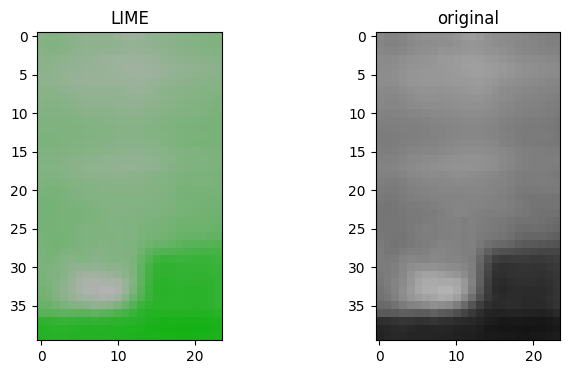

type of cell :
Vegetation
type of cell predicted :
1/1 [==============================] - 0s 26ms/step
Vegetation


In [57]:
i = 10

explainer = lime_image.LimeImageExplainer(random_state=42)
explanation = explainer.explain_instance(
         X_train[i],
         model.predict
)
#plt.imshow(X_train[60])
image, mask = explanation.get_image_and_mask(
         model.predict(
              X_train[i].reshape((1,40,24,3))
         ).argmax(axis=1)[0],
         positive_only=False,
         hide_rest=False)

# Plotting side by side
plt.figure(figsize=(8, 4))


plt.subplot(1, 2, 1)
plt.imshow(mark_boundaries(image, mask))
plt.title("LIME")

# Plot the second image on the right
plt.subplot(1, 2, 2)
plt.imshow(X_train[i])
plt.title("original")

plt.show()
print("type of cell :" )
print(dict[y_train[i]])

print("type of cell predicted :" )
pred = model.predict(X_train[i].reshape((1,40,24,3)))
print(dict[np.argmax(pred)])


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 17ms/step


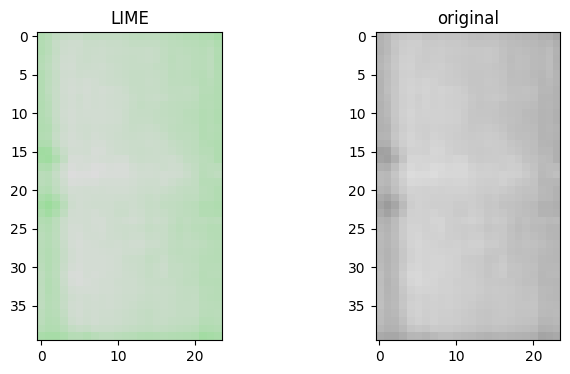

type of cell :
No-Anomaly
type of cell predicted :
1/1 [==============================] - 0s 18ms/step
No-Anomaly


In [59]:
i = 0

explainer = lime_image.LimeImageExplainer(random_state=42)
explanation = explainer.explain_instance(
         X_train[i],
         model.predict
)
#plt.imshow(X_train[60])
image, mask = explanation.get_image_and_mask(
         model.predict(
              X_train[i].reshape((1,40,24,3))
         ).argmax(axis=1)[0],
         positive_only=False,
         hide_rest=False)

# Plotting side by side
plt.figure(figsize=(8, 4))


plt.subplot(1, 2, 1)
plt.imshow(mark_boundaries(image, mask))
plt.title("LIME")

# Plot the second image on the right
plt.subplot(1, 2, 2)
plt.imshow(X_train[i])
plt.title("original")

plt.show()
print("type of cell :" )
print(dict[y_train[i]])

print("type of cell predicted :" )
pred = model.predict(X_train[i].reshape((1,40,24,3)))
print(dict[np.argmax(pred)])


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 29ms/step


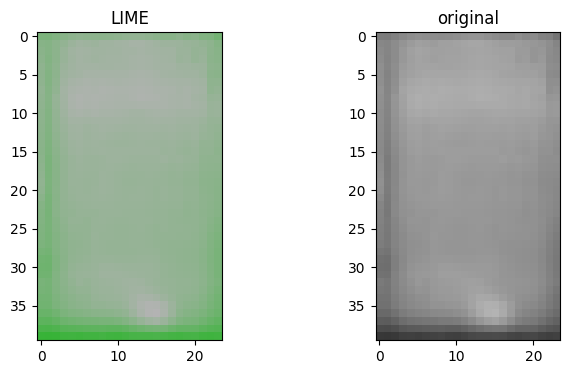

type of cell :
Cell
type of cell predicted :
1/1 [==============================] - 0s 35ms/step
Cell


In [60]:
i = 23

explainer = lime_image.LimeImageExplainer(random_state=42)
explanation = explainer.explain_instance(
         X_train[i],
         model.predict
)
#plt.imshow(X_train[60])
image, mask = explanation.get_image_and_mask(
         model.predict(
              X_train[i].reshape((1,40,24,3))
         ).argmax(axis=1)[0],
         positive_only=False,
         hide_rest=False)

# Plotting side by side
plt.figure(figsize=(8, 4))


plt.subplot(1, 2, 1)
plt.imshow(mark_boundaries(image, mask))
plt.title("LIME")

# Plot the second image on the right
plt.subplot(1, 2, 2)
plt.imshow(X_train[i])
plt.title("original")

plt.show()
print("type of cell :" )
print(dict[y_train[i]])

print("type of cell predicted :" )
pred = model.predict(X_train[i].reshape((1,40,24,3)))
print(dict[np.argmax(pred)])


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 17ms/step


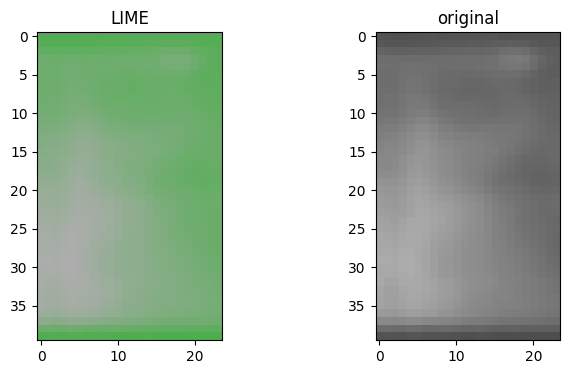

type of cell :
Shadowing
type of cell predicted :
1/1 [==============================] - 0s 18ms/step
Shadowing


In [61]:
i = 26

explainer = lime_image.LimeImageExplainer(random_state=42)
explanation = explainer.explain_instance(
         X_train[i],
         model.predict
)
#plt.imshow(X_train[60])
image, mask = explanation.get_image_and_mask(
         model.predict(
              X_train[i].reshape((1,40,24,3))
         ).argmax(axis=1)[0],
         positive_only=False,
         hide_rest=False)

# Plotting side by side
plt.figure(figsize=(8, 4))


plt.subplot(1, 2, 1)
plt.imshow(mark_boundaries(image, mask))
plt.title("LIME")

# Plot the second image on the right
plt.subplot(1, 2, 2)
plt.imshow(X_train[i])
plt.title("original")

plt.show()
print("type of cell :" )
print(dict[y_train[i]])

print("type of cell predicted :" )
pred = model.predict(X_train[i].reshape((1,40,24,3)))
print(dict[np.argmax(pred)])


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 17ms/step


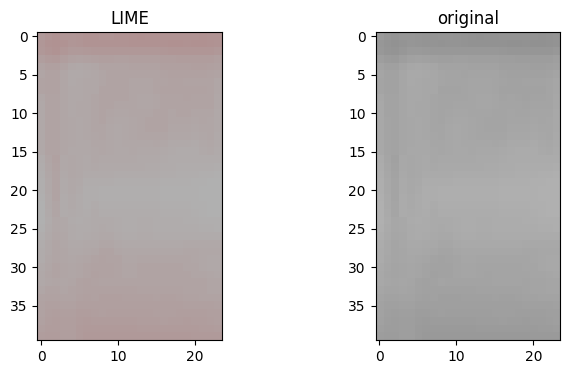

type of cell :
No-Anomaly
type of cell predicted :
1/1 [==============================] - 0s 20ms/step
No-Anomaly


In [62]:
i = 2

explainer = lime_image.LimeImageExplainer(random_state=42)
explanation = explainer.explain_instance(
         X_test[i],
         model.predict
)
#plt.imshow(X_train[60])
image, mask = explanation.get_image_and_mask(
         model.predict(
              X_test[i].reshape((1,40,24,3))
         ).argmax(axis=1)[0],
         positive_only=False,
         hide_rest=False)

# Plotting side by side
plt.figure(figsize=(8, 4))


plt.subplot(1, 2, 1)
plt.imshow(mark_boundaries(image, mask))
plt.title("LIME")

# Plot the second image on the right
plt.subplot(1, 2, 2)
plt.imshow(X_test[i])
plt.title("original")

plt.show()
print("type of cell :" )
print(dict[y_test[i]])

print("type of cell predicted :" )
pred = model.predict(X_test[i].reshape((1,40,24,3)))
print(dict[np.argmax(pred)])


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 18ms/step


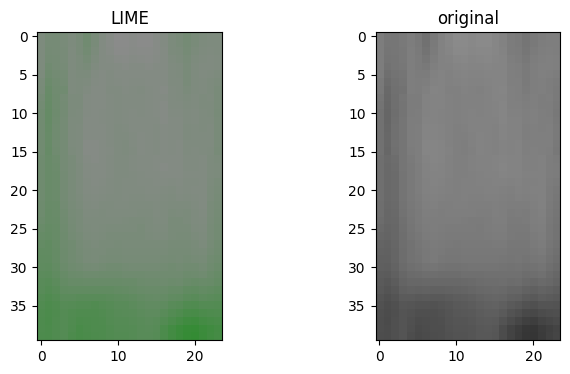

type of cell :
No-Anomaly
type of cell predicted :
1/1 [==============================] - 0s 18ms/step
No-Anomaly


In [63]:
i = 56

explainer = lime_image.LimeImageExplainer(random_state=42)
explanation = explainer.explain_instance(
         X_test[i],
         model.predict
)
#plt.imshow(X_train[60])
image, mask = explanation.get_image_and_mask(
         model.predict(
              X_test[i].reshape((1,40,24,3))
         ).argmax(axis=1)[0],
         positive_only=False,
         hide_rest=False)

# Plotting side by side
plt.figure(figsize=(8, 4))


plt.subplot(1, 2, 1)
plt.imshow(mark_boundaries(image, mask))
plt.title("LIME")

# Plot the second image on the right
plt.subplot(1, 2, 2)
plt.imshow(X_test[i])
plt.title("original")

plt.show()
print("type of cell :" )
print(dict[y_test[i]])

print("type of cell predicted :" )
pred = model.predict(X_test[i].reshape((1,40,24,3)))
print(dict[np.argmax(pred)])


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 26ms/step


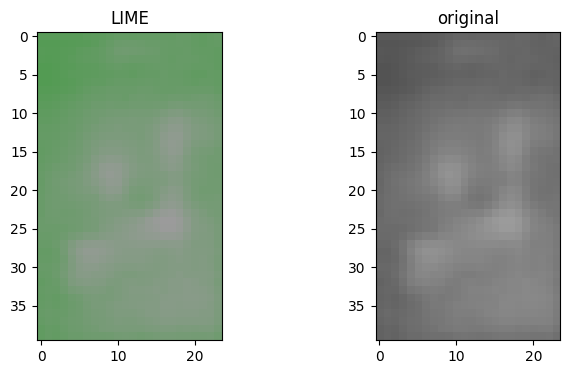

type of cell :
Shadowing
type of cell predicted :
1/1 [==============================] - 0s 28ms/step
Cracking


In [64]:
i = 10

explainer = lime_image.LimeImageExplainer(random_state=42)
explanation = explainer.explain_instance(
         X_test[i],
         model.predict
)
#plt.imshow(X_train[60])
image, mask = explanation.get_image_and_mask(
         model.predict(
              X_test[i].reshape((1,40,24,3))
         ).argmax(axis=1)[0],
         positive_only=False,
         hide_rest=False)

# Plotting side by side
plt.figure(figsize=(8, 4))


plt.subplot(1, 2, 1)
plt.imshow(mark_boundaries(image, mask))
plt.title("LIME")

# Plot the second image on the right
plt.subplot(1, 2, 2)
plt.imshow(X_test[i])
plt.title("original")

plt.show()
print("type of cell :" )
print(dict[y_test[i]])

print("type of cell predicted :" )
pred = model.predict(X_test[i].reshape((1,40,24,3)))
print(dict[np.argmax(pred)])


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 27ms/step


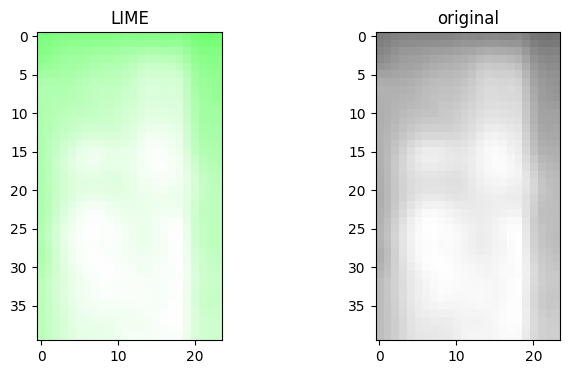

type of cell :
Cell-Multi
type of cell predicted :
1/1 [==============================] - 0s 19ms/step
Cell-Multi


In [65]:
i = 102

explainer = lime_image.LimeImageExplainer(random_state=42)
explanation = explainer.explain_instance(
         X_test[i],
         model.predict
)
#plt.imshow(X_train[60])
image, mask = explanation.get_image_and_mask(
         model.predict(
              X_test[i].reshape((1,40,24,3))
         ).argmax(axis=1)[0],
         positive_only=False,
         hide_rest=False)

# Plotting side by side
plt.figure(figsize=(8, 4))


plt.subplot(1, 2, 1)
plt.imshow(mark_boundaries(image, mask))
plt.title("LIME")

# Plot the second image on the right
plt.subplot(1, 2, 2)
plt.imshow(X_test[i])
plt.title("original")

plt.show()
print("type of cell :" )
print(dict[y_test[i]])

print("type of cell predicted :" )
pred = model.predict(X_test[i].reshape((1,40,24,3)))
print(dict[np.argmax(pred)])
